# Predicting Home Values in Southern California
#### Brought to you by Caitlyn Carney

My goals today are to predict home values in southern Califiornia as accuratly as possible.

My thoughts as that the number of bedrooms, bathrooms and amount of square footage affects home value prices in southern California.

I will do this all by:
- Gather and clean Zillow data
- Explore data and finding what it means.
- Evaluating and modeling the data.

My key findings during this project was that appraisal value in southern California is driven by many features. But that the number of bedrooms, bathrooms, as well as square footage were the biggest individual drivers of the appraised value.

My takeaways after finishing this was that square feet, 
bedrooms, and bathrooms do have an affect the appraisal value of homes in southern California.

In [1]:
from env import host, user, password
import acquire
import prepare
import explore
import evaluate
import model

# Aquire Zillow Data
This data was obtained through the Zillow database through Codeup Sequel server.
- For more detail on the SQL query used to gather the data please see the acquire.py found in the github repository.

In [2]:
df = acquire.acquire_zillow()
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,None,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,None,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,None,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30


# Prepare/Clean the Data
This is some messy data! We need to get this cleaned up and easier to use!


*But how will we do this?*
- By **creating new features** `house age` and `tax_rate`
- **dropping all columns with less than 35 thousand non null values.**
    - this means each feature needs to have at least 90% non null values
- **Remove features**
    - calculatedbathnbr, finishedsquarefeet12, propertycountylandusecode, logerror, transactiondate, yearbuilt, taxvaluedollarcnt, landtaxvaluedollarcnt, rawcensustractandblock
- **Rename features**
    - bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, fullbathcnt, regionidzip, regionidcity, regionidcounty
- **Handle Outliers** using the IQR rule for features
    - appraised_value, square_feet, bedrooms
    
For more detail on the code used to clean the data please see the prepare.py on the github repository

In [3]:
df = prepare.clean_zillow(df)

In [4]:
df.head()

,parcelid,bathrooms,bedrooms,square_feet,fips,full_baths,latitude,longitude,house_type,city,county,zip_code,roomcnt,appraised_value,assessmentyear,taxamount,house_age,tax_rate
0,14634203,2.0,3.0,1125.0,6059.0,2.0,33922098.0,-117954970.0,266.0,18874.0,1286.0,96186.0,6.0,289445.0,2016.0,3490.16,47.0,82.931728
1,11721753,2.0,3.0,1316.0,6037.0,2.0,34033180.0,-118355396.0,261.0,12447.0,3101.0,95997.0,0.0,205123.0,2016.0,2627.48,98.0,78.068339
2,11289917,2.0,3.0,1458.0,6037.0,2.0,34686163.0,-118113100.0,261.0,5534.0,3101.0,97318.0,0.0,136104.0,2016.0,2319.90,51.0,58.668046
3,11637029,2.0,3.0,1766.0,6037.0,2.0,34073222.0,-118390965.0,266.0,10389.0,3101.0,96086.0,0.0,810694.0,2016.0,9407.01,41.0,86.179774
4,11705026,1.0,2.0,1421.0,6037.0,1.0,33999877.0,-118291863.0,261.0,12447.0,3101.0,96018.0,0.0,35606.0,2016.0,543.69,110.0,65.489525


# Lets Start Exploring!

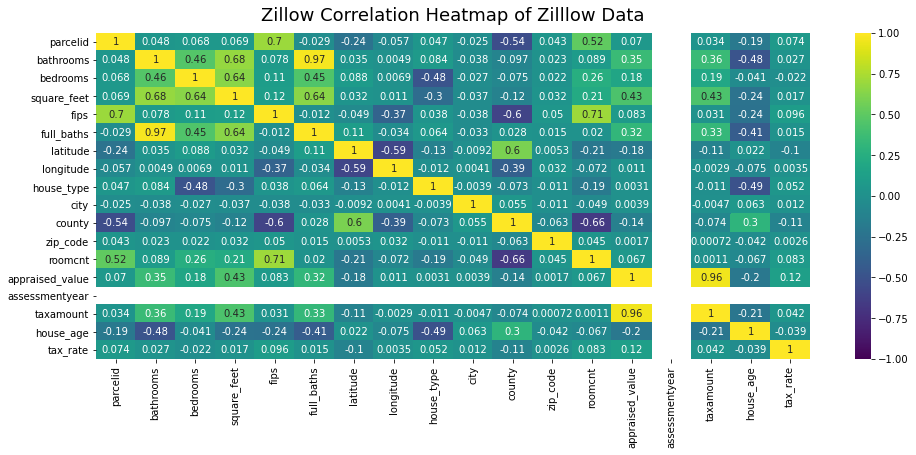

In [5]:
explore.plot_zillow_heatmap()

Above is a correlation heatmap for the cleaned zillow data set.
- My target is `appraised_value`
    - Strongest correlations are
        - square_feet
            - 0.43
        - bathrooms
            - 0.35
        - bedrooms
            - 0.18
        - lattitude
            - -0.18
        - county
            - -0.14
        - house_age
            - 0.13
        - tax_rate
            - 0.12
            
I decided to focus on square feet, bathrooms, and bedrooms.

## Tax Rate Distribution

def tax_rate_dist():
    '''
    This function creates the dataframe used to calculate the tax distribution rate per county. 
    '''
    df = acquire.acquire_zillow()
    df = prepare.clean_zillow(df)
    df.set_index('parcelid', inplace=True)
    features = ['fips', 'taxvaluedollarcnt', 'taxamount']
    df = df[features]
    
    df.columns = ['fips', 'tax_value', 'tax_amount']
    
    df = df.dropna()
    
    df['tax_rate'] = (df.tax_amount / df.tax_value)
    
    df = remove_outliers(df, 'tax_rate', 2.5)
    df = remove_outliers(df, 'tax_value', 2.5)
    
    return df
tax_rate_dist()

In [6]:
def tax_rate_dist():
    '''
    This function creates the dataframe used to calculate the tax distribution rate per county. 
    '''
    tax = acquire.acquire_zillow()
    tax.set_index('parcelid', inplace=True)
    features = ['fips', 'taxvaluedollarcnt', 'taxamount']
    tax = tax[features]
    tax.columns = ['fips', 'tax_value', 'tax_amount']
    
    tax = tax.dropna()
    
    tax['tax_rate'] = (tax.tax_amount / tax.tax_value)
    
    tax = prepare.remove_outliers(tax, 'tax_rate', 2.5)
    tax = prepare.remove_outliers(tax, 'tax_value', 2.5)
    
    return tax
tax_rate_dist()

,fips,tax_value,tax_amount,tax_rate
parcelid,,,,
14634203,6059.0,289445.0,3490.16,0.012058
11721753,6037.0,205123.0,2627.48,0.012809
11289917,6037.0,136104.0,2319.90,0.017045
11637029,6037.0,810694.0,9407.01,0.011604
11705026,6037.0,35606.0,543.69,0.015270
...,...,...,...,...
14453399,6059.0,852813.0,11662.88,0.013676
12019061,6037.0,492395.0,6023.37,0.012233
11570288,6037.0,600608.0,7255.87,0.012081


prepare.tax_rate_dist()

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

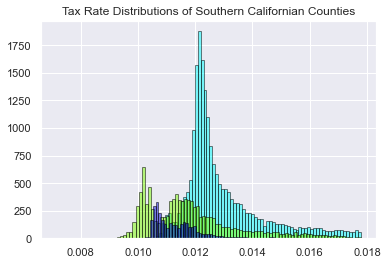

In [20]:
def show_tax_rate_dist():
    '''this takes the tax_rate_dist and shows it'''
    
    tax = tax_rate_dist()
    sns.set(style="darkgrid")
    plt.hist(data=tax[tax.fips == 6037], x='tax_rate', bins=100, color='cyan', alpha=.5, ec='black', label='Los Angeles County')
    plt.hist(data=tax[tax.fips == 6059], x='tax_rate',  bins=100, color='lawngreen', alpha=.5, ec='black', label='Orange County')
    plt.hist(data=tax[tax.fips == 6111], x='tax_rate', bins=100, color="mediumblue", alpha=.5, ec='black', label='Ventura County')

    plt.title('Tax Rate Distributions of Southern Californian Counties')
    
show_tax_rate_dist()

prepare.show_tax_rate_dist()

## Explore the Train Data Set

Start by splitting your data
- for more information on the code used to explore please see the explore.py on the github repository.

#### Split the Data

In [ ]:
train, validate, test = prepare.split_focused_zillow(df)

#### Scale the Data

In [ ]:
train_scaled, validate_scaled, test_scaled = prepare.scale_focused_zillow(train, validate, test)

Lets focus on just train data set while we start exploring and put scaled in our back pocket for later

In [ ]:
explore.plot_train_heatmap()

Here we can see a correlation heatmap specifically on the train data set
- The darker blue represents a stronger positive correlation between two features
- The yellow the stronger the negative correlation between 2 features
- The correlations to the `appraise_value` feature are:
    - `square_feet`
        - 0.43
            - positive correlation
    - `bathrooms`
        - 0.36
            - positive correlation
    - `bedrooms`
        - 0.18
            - positive correlation


## Using Scatterplots to see the Relationships to Appraised Value

In [ ]:
explore.plot_scatter_plots()

Takeaways of Relationship Scatter Plots:
- I can definatly see a relationship between `appraise_value` and `square_feet`
- There seems to be a noticeable difference in the amount of homes with a low appraised value and low square footage vs. homes with a higher appraised value's square footage
    - the lowe the 
- Homes with 1 bedroom seem to drop off when appraised values get higher while the 2+ bedroom houses seem to contiue rising with the appraised value

In [ ]:
explore.train_pairplot()

Takeaways:
- We can ignore where features overlap theselves because it is not helpful.
- It seems as though if homes wiht more bathrooms and larger amount of square feet tend to be appraised at a higher amount.
    - this is seen in the top right graph
        - the yellow which indicated the higher apppraisal rate takes up mosre population the higher the bathroom number and amount of square feet get
- we can see a gradual increase in appraisal price in the bedrooms and bathrooms relationship.
    - when both features are high we move into higher appraisal values
        - indicated by the green
    - and the lower amount the features are the lower the amount the appraisal value seems to become
        - indicated by dark blue

## Explore Bathroom Feature

**Null Hypothesis** : 
- "There is no correlation between number of bathrooms and appraised value."

**Alternative Hypothesis** :
- "There is a correlation between number of bathrooms and appraised value."

In [ ]:
explore.bathroom_corr()

## Explore Bedroom Feature
**Null Hypothesis** : 
- "There is no correlation between number of bedrooms and appraised value."

**Alternative Hypothesis** :
- "There is a correlation between number of bedrooms and appraised value."


In [ ]:
explore.bedroom_corr()

## Explore Square Feet Feature
**Null Hypothesis** : 
- "There is no correlation between a homes square footage and appraised value."

**Alternative Hypothesis** : 
- "There is a correlation between square feet and appraised value."

In [ ]:
explore.square_feet_corr()

## Evaluation Time
For more informaiton on the code used in the evaluation stage please see the evaluation.py found in the github repository.

In [ ]:
y_train, y_validate = evaluate.eval_y_train()
y_train.head()

I will continue with using baseline median

In [ ]:
SSE, SSE_baseline, MSE, MSE_baseline, RMSE, RMSE_baseline = evaluate.SSE_MSE_RMSE()

In [ ]:
evaluate.SSE_MSE_RMSE_info()

# Lets Start Modeling!
For more detail on code used please see model.py.

## Establish the baseline

In [ ]:
model.get_baseline()

## Evaluate each model

In [ ]:
model.all_models_info()

## Choosing the Model

In [ ]:
model.choose_best_model()

## Plotting Actual vs. Predicted Values

In [ ]:
model.plot_actual_and_pred()

## Visualize Actual vs Predicted with Histograms

In [ ]:
model.hist_ols_appraised_value()

## Residual Plots: Plotting the Errors in Predictions

In [ ]:
model.plot_ols_errors()